# Text mining & Search Project

### Università degli Studi di Milano-Bicocca  2020/2021

**Luzzi Federico** (matricola) **Peracchi Marco** 800578

In [1]:
import nltk
import re
import os
from gensim.models.doc2vec import Doc2Vec, TaggedDocument # doc2vec
import pandas as pd
import numpy as np
import pickle

In [2]:
# models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
# results
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from utils import c_matrix
from process_text import processing # preprocessing functions
from features import *

In [4]:
#setting working directory
#os.chdir("C:/Users/fede9/Documents/GitHub/textmining/code")
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Marco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Marco\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Marco\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Preprocess text

In [4]:
if 'processed_data.csv' not in os.listdir('../data'):
    # load dataset
    df = pd.read_csv("../data/labeled_data.csv", sep = ",").drop("Unnamed: 0", axis=1)
    # apply process_text
    df["tweet_clean"] = df["tweet"].apply(lambda x : processing(x))
    df.to_csv('../data/processed_data.csv', index = False)
else:
    df = pd.read_csv("../data/processed_data.csv", sep = ",")
print("Load & preprocessing --- DONE")

Load & preprocessing --- DONE


In [5]:
# drop tweet list na !!!
df["tweet_list"] = df["tweet_clean"].str.split(" ").tolist()
df.dropna(inplace = True)
df = df.reset_index(drop = True)# drop 2 NA because tweet is empty

&8220 = "

&8221 = "

&amp; = &

&#128514 = Lacrime dal ridere

## Doc2vec

In [10]:
### doc2vec
# generate model of vectorization
if 'd2v.model' not in os.listdir('../models'):
    documents = [TaggedDocument (doc, [i]) for i, doc in enumerate(df["tweet_list"])]
    model = Doc2Vec (documents, vector_size=100, window=10, min_count=1)
    model.save("../models/d2v.model")
else:
    model = Doc2Vec.load("../models/d2v.model")
print("Doc2Vec model --- DONE")

Doc2Vec model --- DONE


## Vectorization (for doc2vec)

In [11]:
### vectorization
# vettori per tutti i documenti
df["vectors"] = df["tweet_list"].apply(lambda x: model.infer_vector(x))
print("Vectorization --- DONE")

Vectorization --- DONE


## TF-IDF

In [6]:
vectorizer = TfidfVectorizer(
    use_idf=True,
    max_features=100,
    min_df=5,
    max_df=0.501
    # , ngram_range=(1, 3) Il miglire rimane uni-gram, pessimo score del bi-gram
    )

In [7]:
tfidf = vectorizer.fit_transform(df["tweet_clean"]).toarray()

In [8]:
tfidf.shape

(24781, 100)

## Vader Sentiment

In [30]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Marco\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [31]:
sentiments = []
sentiment_analyzer = VS()
for tweet in df['tweet_clean']:
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    sentiments.append(sentiment)

In [32]:
print(len(sentiments))
print(sentiments[:5])

24781
[{'neg': 0.0, 'neu': 0.791, 'pos': 0.209, 'compound': 0.2755}, {'neg': 0.259, 'neu': 0.741, 'pos': 0.0, 'compound': -0.5423}, {'neg': 0.841, 'neu': 0.159, 'pos': 0.0, 'compound': -0.9423}, {'neg': 0.0, 'neu': 0.444, 'pos': 0.556, 'compound': 0.3612}, {'neg': 0.457, 'neu': 0.37, 'pos': 0.173, 'compound': -0.6808}]


In [33]:
df['tweet_clean'][3]

'look like tranny'

In [23]:
a = "save the motherfucker"

In [24]:
sentiment_analyzer.polarity_scores(a)

{'neg': 0.523, 'neu': 0.114, 'pos': 0.364, 'compound': -0.34}

In [34]:
neg = []
neu = []
pos = []
compound = []
for sentiment in sentiments:
    neg.append(sentiment['neg'])
    neu.append(sentiment['neu'])
    pos.append(sentiment['pos'])
    compound.append(sentiment['compound']) 

# save in dataframe  
df['neg'] = neg
df['neu'] = neu
df['pos'] = pos
df['compound'] = compound

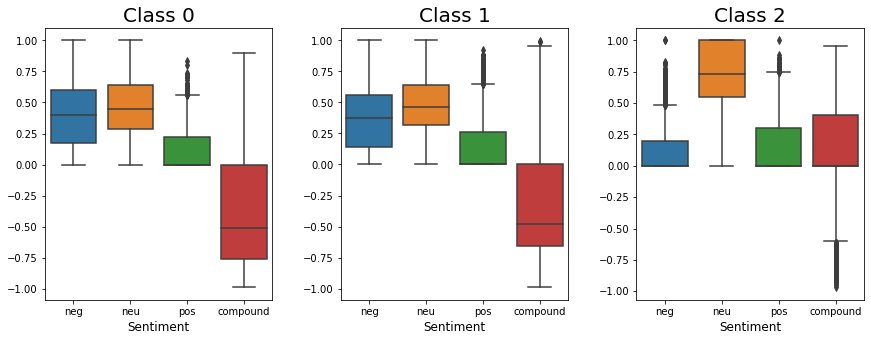

In [35]:
selected_columns = ["neg", "neu", "pos", "compound"]

fig, axs = plt.subplots(ncols = 3, figsize=(13,5))
for i in range(3):
    sns.boxplot(x="variable", y="value", data=pd.melt(df[df['class'] == i][selected_columns]), ax = axs[i])
    axs[i].set_title(f"Class {i}", size = 20)
    axs[i].set_xlabel("Sentiment", size = 12)
    axs[i].set_ylabel("")
    #axs[i].set_xticks(size = 12)
    #axs[i].set_yticks(size = 12)
plt.subplots_adjust(right = 1, wspace = 0.3)

## Features

### - Retweet

In [9]:
df["rt"] = df["tweet"].apply(lambda x : retweet(x))

### - Tweet's length

In [13]:
df["len"] = df["tweet_clean"].apply(lambda x : tweet_length(x))

### - Reply

In [14]:
df["num_rep"] = df["tweet"].apply(lambda x : reply_tweet(x))

### - Number of !

In [15]:
df["num_exc"] = df["tweet"].apply(lambda x : exclamation(x))

### - Emoji

http://www.iemoji.com/view/emoji/61/smileys-people/victory-hand

Al valore *Decimal HTML Entity*

In [16]:
df["emoji"] = df["tweet"].apply(lambda x : emoji(x)) # Conta semplicemente il numero di faccine

## Text classification

In [57]:
# prepare data
#X_data = np.stack(df["vectors"], axis = 0)
#X_data = tfidf
X_data = pd.concat([pd.DataFrame(tfidf), df[["neg", "neu", "pos", "compound"]]], axis = 1)
Y_data = df["class"]

# verifica dimensioni vettori
assert X_data.shape[0] == Y_data.shape[0]

In [58]:
# split train-test
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data,
                                                   test_size = 0.2,
                                                   random_state = 42,
                                                   shuffle = True,
                                                   stratify = Y_data)

assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

In [59]:
# class weights
# w_J = n_samples / (n_classes * n_samples_J)
weights = len(df['class']) / (3 * df['class'].value_counts())
# model
model = SVC(random_state = 42, 
            class_weight= {0 : weights[0], 1 : weights[1], 2 : weights[2]})

In [60]:
%%time
# fitting
model.fit(X_train, y_train)
print("Modelling --- DONE")

Modelling --- DONE
Wall time: 36 s


In [30]:
# save model
filename = 'svm_retweet.sav'
pickle.dump(model, open(f'../models/{filename}', 'wb'))

In [18]:
# load model
filename = 'svm_sentiment.sav'
model_2 = pickle.load(open(f'../models/{filename}', 'rb'))

## Comments

Modelli e risultati di accuracy sul test
- 10000 tfidf best model yet 92% (**non mi ricordo spero sia corretta**)
- 10000 tfidf, 4 sentiment riduce un pochino la performance 83% (**non ricordo quanto fosse**)
- 100 tfidf, retweet **83%**
- 10000 tfidf, retweet *24 min* **89%**
- 100 tfidf tutte le features esclusa la sentiment **60%**
- 100 tfidf, retweet & sentiment **83%**
- 100 tfidf, tutte le feature + sentiment **54%** 
- 100 tfidf **84%**


Sembra che l'utilizzo di feature peggiori il classificatore, quindi sembra che convenga utilizzarlo senza features

## Performance

### Train

Classification report:
              precision    recall  f1-score   support

           0       0.35      0.81      0.49      1144
           1       0.99      0.83      0.90     15351
           2       0.75      0.97      0.84      3329

    accuracy                           0.85     19824
   macro avg       0.70      0.87      0.75     19824
weighted avg       0.91      0.85      0.87     19824



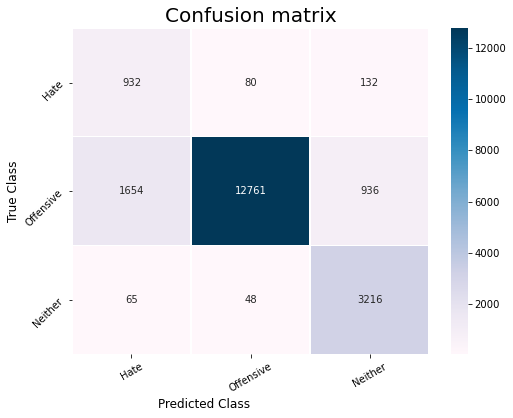

Wall time: 31 s


In [61]:
%%time
# performance on TRAIN
y_pred = model.predict(X_train)   
print('Classification report:')
print(classification_report(y_train, y_pred))
c_matrix(y_train, y_pred, ["Hate", "Offensive", "Neither"])

### Test

Classification report:
              precision    recall  f1-score   support

           0       0.26      0.60      0.37       286
           1       0.97      0.83      0.89      3838
           2       0.74      0.94      0.83       833

    accuracy                           0.83      4957
   macro avg       0.66      0.79      0.70      4957
weighted avg       0.89      0.83      0.85      4957



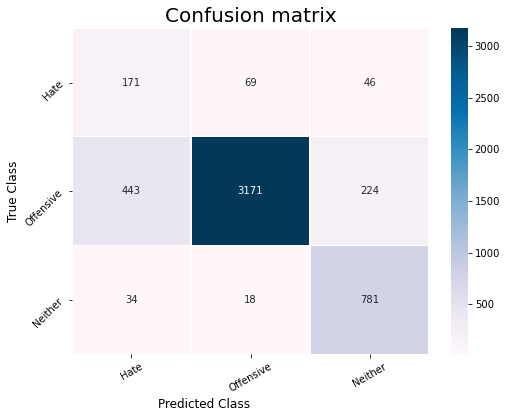

Wall time: 7.63 s


In [62]:
%%time
# performance on TEST
y_pred = model.predict(X_test)   
print('Classification report:')
print(classification_report(y_test, y_pred))
c_matrix(y_test, y_pred, ["Hate", "Offensive", "Neither"]) 

## Unione delle classi

In [65]:
df["binary_class"] = 0
df.loc[(df["class"] == 0) | (df["class"] == 1), "binary_class"] = 1

### Text classification

In [81]:
def classification_SVM_binary(data, label):
    X_data = data
    Y_data = label
    assert X_data.shape[0] == Y_data.shape[0], "X and Y have different shape!"
    # split train-test
    print("Train-Test splitting...")
    X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data,
                                                       test_size = 0.2,
                                                       random_state = 42,
                                                       shuffle = True,
                                                       stratify = Y_data)
    print("-- DONE --")

    assert X_train.shape[0] == y_train.shape[0], "X and Y have different shape!"
    assert X_test.shape[0] == y_test.shape[0], "X and Y have different shape!"
    # class weights
    # w_J = n_samples / (n_classes * n_samples_J)
    print("Computing weights...")
    weights = len(df['binary_class']) / (2 * df['binary_class'].value_counts())
    # model
    model = SVC(random_state = 42,
                class_weight= {0 : weights[0], 1 : weights[1]})
    print("-- DONE --")
    # fitting
    print("Fitting...")
    model.fit(X_train, y_train)
    print("-- DONE --")
    y_pred = model.predict(X_test)   
    print('Classification report:')
    print(classification_report(y_test, y_pred))
    c_matrix(y_test, y_pred, ["Hate-Offensive", "Neither"])


Train-Test splitting...
-- DONE --
Computing weights...
-- DONE --
Fitting...
-- DONE --
Classification report:
              precision    recall  f1-score   support

           0       0.73      0.97      0.83       833
           1       0.99      0.93      0.96      4124

    accuracy                           0.94      4957
   macro avg       0.86      0.95      0.90      4957
weighted avg       0.95      0.94      0.94      4957



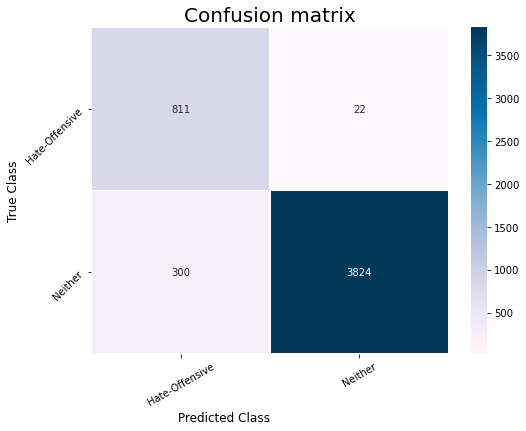

Wall time: 17.5 s


In [82]:
%%time
classification_SVM_binary(tfidf, df["binary_class"])

## Comments

Modelli e risultati di accuracy sul test
- 100 tfidf **94%**

In [ ]:
#Funzione he ho definito per l'inizio ma non mi piace
def classification_SVM(data, label):
    X_data = data
    Y_data = label
    assert X_data.shape[0] == Y_data.shape[0], "X and Y have different shape!"
    # split train-test
    print("Train-Test splitting...")
    X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data,
                                                       test_size = 0.2,
                                                       random_state = 42,
                                                       shuffle = True,
                                                       stratify = Y_data)
    print("-- DONE --")

    assert X_train.shape[0] == y_train.shape[0], "X and Y have different shape!"
    assert X_test.shape[0] == y_test.shape[0], "X and Y have different shape!"
    # class weights
    # w_J = n_samples / (n_classes * n_samples_J)
    print("Computing weights...")
    weights = len(df['class']) / (3 * df['class'].value_counts())
    # model
    model = SVC(random_state = 42,
                class_weight= {0 : weights[0], 1 : weights[1], 2 : weights[2]})
    print("-- DONE --")
    # fitting
    print("Fitting...")
    model.fit(X_train, y_train)
    print("-- DONE --")
    y_pred = model.predict(X_train)   
    print('Classification report:')
    print(classification_report(y_test, y_pred))
    c_matrix(y_test, y_pred, ["Hate", "Offensive", "Neither"])